In [28]:
import geopandas as gpd
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.geometry import Point, Polygon
import googlemaps
import re
import string
import requests
from tqdm.auto import tqdm
from unidecode import unidecode
import numpy as np

tqdm.pandas()
pd.set_option('display.max_columns', None)

#city = "Porto"
city = "Lisboa"

CAOP11 = gpd.read_file("data/freguesias/CAOP2011.shp")
CAOP23 = gpd.read_file("data/freguesias/CAOP2023.shp")

if city == "Porto":
    CAOP = CAOP11[CAOP11["MUNICIPIO"] == "PORTO"][["FREGUESIA", "geometry"]]
    CAOP11 = CAOP11[CAOP11["MUNICIPIO"] == "PORTO"][["FREGUESIA", "geometry"]]

elif city == "Lisboa":
    CAOP11 = CAOP11[(CAOP11["MUNICIPIO"] == "LISBOA") & (CAOP11["TAA"] == "ÁREA PRINCIPAL")][["FREGUESIA", "geometry"]]  
    CAOP = CAOP23[CAOP23["Municipio"] == "Lisboa"][["Freguesia", "geometry"]]
    CAOP = CAOP.rename(columns={"Municipio": "MUNICIPIO", "Freguesia": "FREGUESIA"})

CAOP = CAOP.to_crs("EPSG:4326")

if city == "Porto":
    airbnb = pd.read_csv("data/airbnb/porto.csv")
    airbnb = airbnb[airbnb["neighbourhood_group"] == "PORTO"]
    gdf = gpd.read_file('data/geojson/porto.geojson')
    joao = pd.read_csv("data/rnal/joao_rnal_porto.csv", sep=";")
elif city == "Lisboa":
    airbnb = pd.read_csv("data/airbnb/lisboa.csv")
    airbnb = airbnb[airbnb["neighbourhood_group"] == "Lisboa"]
    gdf = gpd.read_file('data/geojson/lisboa.geojson')
    joao = pd.read_csv("data/rnal/joao_rnal_lisboa.csv")
rnal = pd.read_csv("data/rnal/rnal_travelBI.csv")

polygon = gdf.geometry[0]
def is_inside(row):
    point = Point(row['X'], row['Y'])
    return polygon.contains(point)
    
rnal['is_inside'] = rnal.apply(is_inside, axis=1)
rnal = rnal[rnal['is_inside'] == True].drop("is_inside", axis=1)
rnal['DataAberturaPublico'] = rnal['DataAberturaPublico'].apply(lambda x: pd.to_datetime(x).date())
rnal['DataRegisto'] = rnal['DataRegisto'].apply(lambda x: pd.to_datetime(x).date())

In [29]:
# Clean the NrRegisto column in joao
joao['NrRegisto'] = joao['NrRegisto'].str.replace('/AL', '')

# Convert NrRegisto to numeric to ensure proper comparison
joao['NrRegisto'] = pd.to_numeric(joao['NrRegisto'], errors='coerce')

# Find the data points in rnal that are not in joao
rnal_not_in_joao = rnal[~rnal['NrRNAL'].isin(joao['NrRegisto'])]

# Find the data points in joao that are not in rnal
joao_not_in_rnal = joao[~joao['NrRegisto'].isin(rnal['NrRNAL'])]

# Find the data points that are in both rnal and joao
both_in_rnal_and_joao = rnal[rnal['NrRNAL'].isin(joao['NrRegisto'])]

# Print the numbers
print("Number of data points in rnal:", rnal.shape[0])
print("Number of data points in joao:", joao.shape[0])
print("Number of data points in both rnal and joao:", both_in_rnal_and_joao.shape[0])
print("Number of data points in joao but not in rnal:", joao_not_in_rnal.shape[0])
print("Number of data points in rnal but not in joao:", rnal_not_in_joao.shape[0])

Number of data points in rnal: 19318
Number of data points in joao: 19151
Number of data points in both rnal and joao: 19129
Number of data points in joao but not in rnal: 22
Number of data points in rnal but not in joao: 189


In [34]:
# Convert DataRegisto to datetime if not already
joao['DataRegisto'] = pd.to_datetime(joao['DataRegisto'])

# Create monthly counts including all data
monthly_counts_joao = (joao.groupby(pd.Grouper(key='DataRegisto', freq='M'))
                       .size()
                       .reset_index(name='count'))

# Ensure all months are included (even those with 0 counts)
date_range_joao = pd.date_range(start=monthly_counts_joao['DataRegisto'].min(), 
                                end=monthly_counts_joao['DataRegisto'].max(),
                                freq='M')
monthly_counts_joao = monthly_counts_joao.set_index('DataRegisto').reindex(date_range_joao).fillna(0)
monthly_counts_joao = monthly_counts_joao.reset_index().rename(columns={'index': 'DataRegisto'})

# Add cumulative count column
monthly_counts_joao['cumulative_count'] = monthly_counts_joao['count'].cumsum()

# Filter to start from January 2014
monthly_counts_joao = monthly_counts_joao[monthly_counts_joao['DataRegisto'] >= '2014-01-01']

# Set the index to month and year as a string
monthly_counts_joao['month_year'] = monthly_counts_joao['DataRegisto'].dt.to_period('M').astype(str)
monthly_counts_joao.set_index('month_year', inplace=True)

# Select only the cumulative_count column
cumulative_counts_joao = monthly_counts_joao['cumulative_count']

# Save to JSON
cumulative_counts_joao.to_json("monthlyCounts.json")

/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_54467/3587342462.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts_joao = (joao.groupby(pd.Grouper(key='DataRegisto', freq='M'))
/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_54467/3587342462.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range_joao = pd.date_range(start=monthly_counts_joao['DataRegisto'].min(),


    Year  Count  Percentage Change
0   1930      2           0.000000
1   1947      1         -50.000000
2   1964      1           0.000000
3   1965      2         100.000000
4   1981      1         -50.000000
5   1983      1           0.000000
6   1985      1           0.000000
7   1992      1           0.000000
8   1995      7         600.000000
9   2003      2         -71.428571
10  2008      5         150.000000
11  2009     20         300.000000
12  2010     58         190.000000
13  2011     52         -10.344828
14  2012     82          57.692308
15  2013    164         100.000000
16  2014    565         244.512195
17  2015   1757         210.973451
18  2016   2637          50.085373
19  2017   3585          35.949943
20  2018   6284          75.285914
21  2019   1973         -68.602801
22  2020    393         -80.081095
23  2021    534          35.877863
24  2022    750          40.449438
25  2023    245         -67.333333
26  2024     28         -88.571429
    Year  Count  Per

/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_54467/945707290.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnal_filtered['Cumulative Count'] = rnal_filtered['Count'].cumsum()


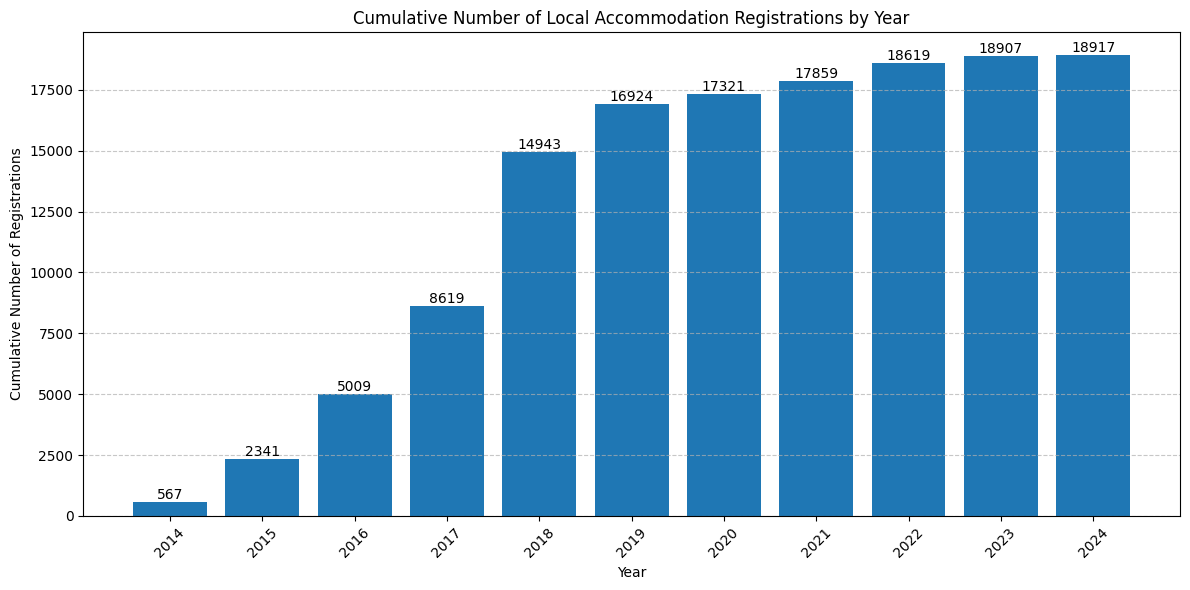

In [26]:
def calculate_yearly_summary(df, date_column):
    df['year'] = df[date_column].apply(lambda x: pd.to_datetime(x).year)
    yearly_counts = df['year'].value_counts().sort_index()
    yearly_percentages = yearly_counts.pct_change().fillna(0) * 100

    yearly_summary = pd.DataFrame({
        'Year': yearly_counts.index,
        'Count': yearly_counts.values,
        'Percentage Change': yearly_percentages.values
    })

    return yearly_summary

# Calculate for joao DataFrame
joao_summary = calculate_yearly_summary(joao, 'DataRegisto')
print(joao_summary)

# Calculate for rnal DataFrame
rnal_summary = calculate_yearly_summary(rnal, 'DataRegisto')
print(rnal_summary)

import matplotlib.pyplot as plt

# Filter data from 2014 onwards
rnal_filtered = rnal_summary[rnal_summary['Year'] >= 2014]

# Calculate cumulative sum
rnal_filtered['Cumulative Count'] = rnal_filtered['Count'].cumsum()

plt.figure(figsize=(12, 6))
plt.bar(rnal_filtered['Year'], rnal_filtered['Cumulative Count'])
plt.title('Cumulative Number of Local Accommodation Registrations by Year')
plt.xlabel('Year')
plt.ylabel('Cumulative Number of Registrations')
plt.xticks(rnal_filtered['Year'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(rnal_filtered['Cumulative Count']):
    plt.text(rnal_filtered['Year'].iloc[i], v, str(int(v)), 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [27]:
# Convert DataRegisto to datetime if not already
rnal['DataRegisto'] = pd.to_datetime(rnal['DataRegisto'])

# Filter data from 2014 onwards and create monthly counts
monthly_counts = (rnal[rnal['DataRegisto'] >= '2014-01-01']
                 .groupby(pd.Grouper(key='DataRegisto', freq='M'))
                 .size()
                 .reset_index(name='count'))

# Ensure all months are included (even those with 0 counts)
date_range = pd.date_range(start='2014-01-01', 
                          end=monthly_counts['DataRegisto'].max(),
                          freq='M')
monthly_counts = monthly_counts.set_index('DataRegisto').reindex(date_range).fillna(0)
monthly_counts = monthly_counts.reset_index().rename(columns={'index': 'DataRegisto'})

# Add cumulative count column
monthly_counts['cumulative_count'] = monthly_counts['count'].cumsum()

# Set the index to month and year as a string
monthly_counts['month_year'] = monthly_counts['DataRegisto'].dt.to_period('M').astype(str)
monthly_counts.set_index('month_year', inplace=True)

# Select only the cumulative_count column
cumulative_counts = monthly_counts['cumulative_count']

# Save to JSON
cumulative_counts.to_json("monthlyCounts.json")



/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_54467/2966329424.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='DataRegisto', freq='M'))
/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_54467/2966329424.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2014-01-01',


In [11]:
rnal.head()

,X,Y,OBJECTID,NrRNAL,Denominacao,DataRegisto,DataAberturaPublico,Modalidade,NrUtentes,Email,Endereco,CodigoPostal,LOCALIDADE,LatLong,FiabilidadeGeo,Freguesia,Concelho,Distrito,NUTSIII,NUTSII,NUTSI,ERT,PNCT,RNAP,RedeNatura2000Global,RedeNatura2000Sitios,RedeNatura2000ZPE,FaixaCosteira,ZonaCosteira,ZonaTerrestreProtecao,LimitePROT,LimitePOC,LimiteAlbufeiras,UNESCO,Geoparques,Biosfera,RedeAldeias,FreguesiasCosteiras,NUTSIIICosteiras,SeloCleanSafe
168,-8.612179,41.145644,203568601,956,bnapartments Loftpuzzle,2014-12-17,2014-12-17,Apartamento,2,staff@bnapartments.com,Largo Lóios 15 1.1,4050-338,Porto,"41,1456437365141 ; -8,61217878991133",NaoFiavel,"União das freguesias de Cedofeita, Santo Ildef...",Porto,Porto,Área Metropolitana do Porto,Norte,Continente,Turismo do Porto e Norte de Portugal,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Faixa Costeira (5km),Zona Costeira (2km),Não abrangido,Norte,Não abrangido,Não abrangido,"Centro Histórico do Porto, Ponte Luiz I e Most...",Não abrangido,Não abrangido,Não Abrangido,Sim,Sim,Não
211,-8.666504,41.150643,203568644,5984,"Qualitalento - Unipessoal, Lda",2014-07-30,2014-07-30,Moradia,0,cristina.cardoso@colunex.pt,Rua Quinta 737,4150-628,Porto,"41,1506425811746 ; -8,66650434588057",NaoFiavel,"União das freguesias de Aldoar, Foz do Douro e...",Porto,Porto,Área Metropolitana do Porto,Norte,Continente,Turismo do Porto e Norte de Portugal,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Faixa Costeira (5km),Zona Costeira (2km),Zona Terrestre de Proteção (margem + 500m),Norte,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não Abrangido,Sim,Sim,Não
220,-8.611242,41.165617,203568653,6029,Pensão Lira Residencial,2012-12-17,2012-12-17,EstabelecimentoHospedagem,0,geral@residencial-lira.com,Rua Vale Formoso 45,4200-511,Porto,"41,165616804368 ; -8,61124222889373",NaoFiavel,Paranhos,Porto,Porto,Área Metropolitana do Porto,Norte,Continente,Turismo do Porto e Norte de Portugal,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Faixa Costeira (5km),Não abrangido,Não abrangido,Norte,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não Abrangido,Sim,Sim,Não
225,-8.611167,41.141814,203568658,6068,Manor House Porto 1ºandar,2011-08-19,2011-08-19,Apartamento,5,poinsard@gmail.com,Rua Dom Hugo 41 1º direito,4050-305,Porto,"41,141814281979 ; -8,61116715718503",NaoFiavel,"União das freguesias de Cedofeita, Santo Ildef...",Porto,Porto,Área Metropolitana do Porto,Norte,Continente,Turismo do Porto e Norte de Portugal,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Faixa Costeira (5km),Zona Costeira (2km),Zona Terrestre de Proteção (margem + 500m),Norte,Não abrangido,Não abrangido,"Centro Histórico do Porto, Ponte Luiz I e Most...",Não abrangido,Não abrangido,Não Abrangido,Sim,Sim,Não
228,-8.611295,41.152476,203568661,6104,"Primetierra Investments, Lda",2014-07-11,2014-07-11,Apartamento,0,atendimento@oportoinn.com,Rua Alferes Malheiro 187 2º frente,4000-056,Porto,"41,1524755522328 ; -8,61129520498394",NaoFiavel,"União das freguesias de Cedofeita, Santo Ildef...",Porto,Porto,Área Metropolitana do Porto,Norte,Continente,Turismo do Porto e Norte de Portugal,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Faixa Costeira (5km),Zona Costeira (2km),Não abrangido,Norte,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não abrangido,Não Abrangido,Sim,Sim,Não


In [25]:
rnal['entradas_repetidas'] = rnal.groupby(['X', 'Y']).transform('size')
min_value = rnal['entradas_repetidas'].min()
max_value = rnal['entradas_repetidas'].max()
rnal['weight'] = (rnal['entradas_repetidas'] - min_value) / (max_value - min_value)


In [26]:
rnal['host_listings_number'] = rnal.groupby('Email')["NrRNAL"].transform('count')
percentage_single_hosts = (rnal['host_listings_number'] == 1).mean() * 100
percentage_super_hosts = (rnal['host_listings_number'] >= 2).mean() * 100
percentage_mega_hosts = (rnal['host_listings_number'] >= 5).mean() * 100

# Print the percentages
print(f"Listings from single hosts: {percentage_single_hosts:.2f}%")
print(f"Listings from super hosts (>= 2): {percentage_super_hosts:.2f}%")
print(f"Listings from mega hosts (>= 5): {percentage_mega_hosts:.2f}%")


Listings from single hosts: 28.28%
Listings from super hosts (>= 2): 71.72%
Listings from mega hosts (>= 5): 47.81%


In [27]:
#joao[joao["TitulardaExploracao_Tipo"] == "Pessoa coletiva"]

print(f"Listings from companies: {joao[joao["TitulardaExploracao_Tipo"] == "Pessoa coletiva"].shape[0] / joao.shape[0] * 100:.2f}%")


Listings from companies: 59.60%


In [307]:
# Filter out the data points with entradas_repetidas > 1
rnal_filtered = rnal[rnal['entradas_repetidas'] > 1]

# For each group, keep only the one with the highest host_listings_number
idx = rnal_filtered.groupby(['X', 'Y'])['host_listings_number'].idxmax()

# Select the rows with the highest host_listings_number
rnal_unique = rnal.loc[idx]

# Combine with the data points where entradas_repetidas == 1
rnal_filtered = pd.concat([rnal[rnal['entradas_repetidas'] == 1], rnal_unique])

# Reset index if necessary
rnal_filtered.reset_index(drop=True, inplace=True)

In [308]:
type_map = {'Apartamento':1,'Moradia':2,'EstabelecimentoHospedagem':3,'EstabelecimentoHospedagemHostel':4,'Quartos':5}
freg_map_porto = {'União das freguesias de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória':1,'Bonfim':2,'União das freguesias de Lordelo do Ouro e Massarelos':3,'Paranhos':4,'União das freguesias de Aldoar, Foz do Douro e Nevogilde':5,'Campanhã':6,'Ramalde':7} 
freg_map_lisboa = {freg: idx for idx, freg in enumerate(rnal_filtered["Freguesia"].unique(), start=1)}

start_date = datetime(2011, 1, 1) # AL licenses start in 2011
end_date = datetime(2024, 9, 25)

geojson = {}
geojson["type"] = "FeatureCollection"
geojson["features"] = []

for idx, single_al in tqdm(rnal_filtered.sort_values(by='host_listings_number', ascending = True).reset_index().iterrows()):
    al_date = single_al.DataAberturaPublico
    al_date = datetime.combine(al_date, datetime.min.time())
    al_entry = {}
    al_entry["type"] = "Feature"
    al_entry["properties"] = {}
    al_entry["properties"]["id"] = idx+1
    al_entry["properties"]["year"] = al_date.strftime('%y')
    al_entry["properties"]["month"] = al_date.strftime('%m')
    
    january_2014 = datetime(2014, 1, 1)
    # Calculate the difference in months between al_date and january_2014
    months_diff = ((al_date.year - january_2014.year) * 12 + al_date.month - january_2014.month) / 128.0  # 113 months between January 2014 and September 2024
    # Ensure the normalized variable is within the range [0, 1]
    normalized_variable = max(0, min(1, months_diff))
    al_entry["properties"]["normalized_date"] = normalized_variable    
    al_entry["properties"]["type"] = type_map[single_al.Modalidade]
    al_entry["properties"]["ts"] = round(min(max((al_date - start_date).days / (end_date - start_date).days, 0), 1), 2)
    if city == "Porto":
        al_entry["properties"]["freg"] = freg_map_porto[single_al.Freguesia]
    elif city == "Lisboa":
        al_entry["properties"]["freg"] = freg_map_lisboa[single_al.Freguesia]
    al_entry["properties"]["weight"] = single_al.weight
    al_entry["properties"]["endereco"] = single_al.Endereco
    al_entry["properties"]["entradas_repetidas"] = single_al.entradas_repetidas
    al_entry["properties"]["host_listings_number"] = single_al.host_listings_number
    al_entry["geometry"] = {}
    al_entry["geometry"]["type"] = "Point"
    al_entry["geometry"]["coordinates"] = [round(single_al.X,6),round(single_al.Y,6)]
    geojson["features"].append(al_entry)

with open(f'output/{city}/al.json', 'w') as fp:
    json.dump(geojson, fp, separators=(',', ':'))


5088it [00:00, 16544.23it/s]


# Secção


In [309]:
if city == "Porto":
    input_file = "data/censos/BGRI_porto.gpkg"
elif city == "Lisboa":
    input_file = "data/censos/BGRI_lisboa.gpkg"
BGRI = gpd.read_file(input_file)
BGRI = BGRI.to_crs("EPSG:4326")
points_gdf = gpd.GeoDataFrame(rnal, geometry=gpd.points_from_xy(rnal['X'], rnal['Y']), crs="EPSG:4326")
points_in_areas = gpd.sjoin(points_gdf, BGRI, how='left', predicate='within')
point_counts = points_in_areas.groupby('BGRI2021').size().reset_index(name='ALs')
merged_df = pd.merge(BGRI, point_counts, on='BGRI2021', how='left')
merged_df['ALs'] = merged_df['ALs'].fillna(0)
merged_df['alojamentos'] = merged_df["N_ALOJAMENTOS_FAMILIARES"]
merged_df["ALs_ALsmaisAlojamentos"] = round(merged_df["ALs"] / (merged_df["N_ALOJAMENTOS_FAMILIARES"] + merged_df["ALs"])*100,1)
merged_df["ALs_ALsmaisAlojamentos"] = merged_df["ALs_ALsmaisAlojamentos"].fillna(0)


intersections = gpd.overlay(merged_df, CAOP, how='intersection')
intersections['intersection_area'] = intersections['geometry'].area
idx = intersections.groupby('BGRI2021')['intersection_area'].idxmax()
result_df = intersections.loc[idx, ['BGRI2021', 'FREGUESIA']]
result_df["BGRI2021"] = result_df["BGRI2021"].astype(int)
result_df = pd.DataFrame(result_df).set_index("BGRI2021")
merged_df["BGRI2021"] = merged_df["BGRI2021"].astype(int)
merged_df = merged_df.set_index("BGRI2021")
result_df = result_df.rename(columns={"FREGUESIA":"Freguesia2011"})
result_df["Freguesia2011"] = result_df["Freguesia2011"].apply(str.title)
merged_df = merged_df.join(result_df, on="BGRI2021", how="left")
merged_df["Freguesia2011_code"] = merged_df['Freguesia2011'].astype('category').cat.codes

/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_57019/4104029439.py:17: UserWarning: `keep_geom_type=True` in overlay resulted in 449 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersections = gpd.overlay(merged_df, CAOP, how='intersection')
/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_57019/4104029439.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersections['intersection_area'] = intersections['geometry'].area


In [310]:
import shapely
pressao_json_seccao = []

geojson = {}
geojson["type"] = "FeatureCollection"
geojson["features"] = []

for idx, single_block in merged_df.reset_index().iterrows():
    censos_entry = {}
    censos_entry["type"] = "Feature"
    censos_entry["geometry"] = {}
    censos_entry["geometry"]["type"] = "MultiPolygon"
    coordinates_list = []
    for polygon in single_block.geometry.geoms:
        coordinates_list.append([(round(x, 6), round(y, 6)) for x, y in polygon.exterior.coords])
    censos_entry["geometry"]["coordinates"] = [coordinates_list]
    censos_entry["properties"] = {}
    censos_entry["properties"]["als"] = single_block.ALs
    censos_entry["properties"]["individuos"] = single_block.N_INDIVIDUOS
    censos_entry["properties"]["alojamentos"] = single_block.alojamentos
    censos_entry["properties"]["propAL"] = single_block.ALs_ALsmaisAlojamentos
    censos_entry["properties"]["freg"] = single_block.Freguesia2011_code
    geojson["features"].append(censos_entry)

with open(f'output/{city}/censosSeccao.json', 'w') as fp:
    json.dump(geojson, fp, separators=(',', ':'))


# Freguesia

In [311]:
CAOPdf = pd.DataFrame(CAOP)
CAOPdf["FREGUESIA"] = CAOPdf["FREGUESIA"].apply(str.title)
CAOPdf = CAOPdf.rename(columns={"FREGUESIA":"Freguesia2011"})
CAOPdf = CAOPdf.set_index("Freguesia2011")

freguesias21 = merged_df.groupby("Freguesia2011").agg({"Freguesia2011_code":"first", "N_INDIVIDUOS":'sum', "ALs":"sum", "N_ALOJAMENTOS_FAMILIARES":"sum"})
freguesias21["ALs_ALsmaisAlojamentos"] = round(freguesias21["ALs"] / (freguesias21["N_ALOJAMENTOS_FAMILIARES"] + freguesias21["ALs"])*100,1)
freguesias21 = freguesias21.join(CAOPdf, on="Freguesia2011", how="left")

In [312]:
freguesias21.head()

,Freguesia2011_code,N_INDIVIDUOS,ALs,N_ALOJAMENTOS_FAMILIARES,ALs_ALsmaisAlojamentos,geometry
Freguesia2011,,,,,,
Aldoar,0,13487.0,33.0,6006.0,0.5,"POLYGON ((-8.66185 41.17696, -8.66154 41.17692..."
Bonfim,1,22978.0,1389.0,14802.0,8.6,"POLYGON ((-8.5893 41.16718, -8.58887 41.16713,..."
Campanhã,2,29666.0,207.0,16022.0,1.3,"POLYGON ((-8.56821 41.17755, -8.56783 41.17728..."
Cedofeita,3,22847.0,1702.0,14951.0,10.2,"POLYGON ((-8.62279 41.16745, -8.62263 41.16745..."
Foz Do Douro,4,10410.0,174.0,5429.0,3.1,"POLYGON ((-8.66608 41.15955, -8.66582 41.15919..."


In [313]:
if city == "Porto":
    input_file = "data/censos/BGRI2011_porto.gpkg"
if city == "Lisboa":
    input_file = "data/censos/BGRI2011_lisboa.gpkg"

BGRI11 = gpd.read_file(input_file)
BGRI11 = BGRI11.to_crs("EPSG:4326")

intersections = gpd.overlay(BGRI11, CAOP, how='intersection')
intersections['intersection_area'] = intersections['geometry'].area
idx = intersections.groupby('BGRI11')['intersection_area'].idxmax()
result_df = intersections.loc[idx, ['BGRI11', 'FREGUESIA']]
result_df["BGRI11"] = result_df["BGRI11"].astype(int)
result_df = pd.DataFrame(result_df).set_index("BGRI11")
BGRI11["BGRI11"] = BGRI11["BGRI11"].astype(int)
BGRI11 = BGRI11.set_index("BGRI11")
result_df = result_df.rename(columns={"FREGUESIA":"Freguesia2011"})
result_df["Freguesia2011"] = result_df["Freguesia2011"].apply(str.title)
BGRI11 = BGRI11.join(result_df, on="BGRI11", how="left")
BGRI11["Freguesia2011_code"] = BGRI11['Freguesia2011'].astype('category').cat.codes

CAOP11 = pd.DataFrame(CAOP11)
CAOP11["FREGUESIA"] = CAOP11["FREGUESIA"].apply(str.title)
CAOP11 = CAOP11.rename(columns={"FREGUESIA":"Freguesia2011"})
CAOP11 = CAOP11.set_index("Freguesia2011")
freguesias11 = BGRI11.groupby("Freguesia2011").agg({"Freguesia2011_code":"first", "N_INDIVIDUOS_RESIDENT":'sum', "N_ALOJAMENTOS_FAMILIARES":"sum"})
freguesias11 = freguesias11.join(CAOP11, on="Freguesia2011", how="left")

/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_57019/1989414673.py:9: UserWarning: `keep_geom_type=True` in overlay resulted in 466 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersections = gpd.overlay(BGRI11, CAOP, how='intersection')
/var/folders/xb/93m1qw1j7v7f2vqnshn4y2tc0000gs/T/ipykernel_57019/1989414673.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersections['intersection_area'] = intersections['geometry'].area


In [314]:
geojson = {}
geojson["type"] = "FeatureCollection"
geojson["features"] = []

for idx, single_block in freguesias21.reset_index().iterrows():
    censos_entry = {}
    censos_entry["type"] = "Feature"
    censos_entry["geometry"] = {}
    censos_entry["geometry"]["type"] = "Polygon"
    coordinates_list = [(round(x, 6), round(y, 6)) for x, y in single_block.geometry.exterior.coords]
    censos_entry["geometry"]["coordinates"] = [coordinates_list]
    censos_entry["properties"] = {}
    censos_entry["properties"]["als"] = single_block.ALs
    censos_entry["properties"]["individuos"] = single_block.N_INDIVIDUOS
    censos_entry["properties"]["alojamentos"] = single_block.N_ALOJAMENTOS_FAMILIARES
    censos_entry["properties"]["propAL"] = single_block.ALs_ALsmaisAlojamentos
    censos_entry["properties"]["freg"] = single_block.Freguesia2011_code
    censos_entry["properties"]["freg_name"] = single_block.Freguesia2011
    censos_entry["properties"]["diff_pop_2011"] = round((single_block["N_INDIVIDUOS"] - freguesias11.loc[single_block.Freguesia2011]["N_INDIVIDUOS_RESIDENT"]) / freguesias11.loc[single_block.Freguesia2011]["N_INDIVIDUOS_RESIDENT"] * 100, 1)
    censos_entry["properties"]["diff_alojamentos_2011"] = round((single_block["N_ALOJAMENTOS_FAMILIARES"] - freguesias11.loc[single_block.Freguesia2011]["N_ALOJAMENTOS_FAMILIARES"]) / freguesias11.loc[single_block.Freguesia2011]["N_ALOJAMENTOS_FAMILIARES"] * 100, 1)
    geojson["features"].append(censos_entry)


with open(f'output/{city}/censosFreguesia.json', 'w') as fp:
    json.dump(geojson, fp, separators=(',', ':'))



In [315]:
print(geojson)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[(-8.661845, 41.176958), (-8.66154, 41.176923), (-8.661116, 41.176954), (-8.657783, 41.177435), (-8.657553, 41.177196), (-8.657106, 41.176543), (-8.656875, 41.176192), (-8.657181, 41.176191), (-8.657659, 41.1762), (-8.658143, 41.176191), (-8.658687, 41.176203), (-8.659392, 41.176222), (-8.659687, 41.176036), (-8.660017, 41.175863), (-8.660534, 41.175607), (-8.66082, 41.175456), (-8.660898, 41.175414), (-8.66091, 41.175409), (-8.661213, 41.175238), (-8.661565, 41.17506), (-8.661721, 41.174944), (-8.662019, 41.174672), (-8.662232, 41.174373), (-8.662446, 41.174134), (-8.662035, 41.173938), (-8.661894, 41.174), (-8.661676, 41.174022), (-8.661553, 41.174025), (-8.660975, 41.174022), (-8.660773, 41.174013), (-8.660671, 41.174013), (-8.660555, 41.173961), (-8.660525, 41.173922), (-8.660493, 41.173887), (-8.660456, 41.173821), (-8.660263, 41.173616), (-8.660151, 41.173547), (-8.65983

In [316]:
print(rnal[(rnal["host_listings_number"] == 1) & (rnal["entradas_repetidas"] == 1)].shape[0])
print(rnal_filtered[rnal_filtered["host_listings_number"] == 1].shape[0])

1753
1869
